# Playing with the ACTS dataset

This notebook continues the work in ActsExample1. I add here some useful code for fetching and cleaning the ACTS data, and then I demonstrate how to bin it into 3D images.

In [1]:
# System
from __future__ import print_function
import os

# Externals
import numpy as np
import matplotlib.pyplot as plt

# Locals
from drawing import draw_3d_event

# Magic
%matplotlib notebook

In [2]:
np.set_printoptions(precision=3)

## Utilities

In [3]:
def calc_eta(theta):
    """Calculates eta from a theta value or flat array"""
    return -1. * np.log(np.tan(theta / 2.))

def calc_phi(rphi, r):
    """Calculates phi from rphi"""
    return rphi / r
# I vectorize it to work on an array of arrays
calc_phi = np.vectorize(calc_phi, otypes='O')

def filter_samples(idx, *arrays):
    """Apply a filter index to a list of arrays"""
    return map(lambda x: x[idx], arrays)

def filter_objects(idx, *arrays):
    """
    Apply array of filter indices to some object arrays.
    Each input array should be an array of arrays (dtype='O').
    """
    filt_func = np.vectorize(lambda x: x[idx], otypes='O')
    return map(lambda a: np.stack(filt_func(a)), arrays)

In [19]:
class ActsData():
    """Empty class for setting variables as attributes"""
    pass

def load_data(filename):
    """
    Retrieve data from one file
    Returns a data object with attributes for each numpy array
    """
    d = ActsData()
    f = np.load(filename, encoding='bytes')
    # Track level truth quantities
    d.true_theta = f['truth_Theta']
    d.true_eta = calc_eta(d.true_theta)
    d.true_phi = f['truth_Phi']
    d.true_qop = f['truth_QoverP']
    d.true_pt = np.abs(1/d.true_qop)
    # Detector hit measurements
    d.nstep = f['Filter_nSteps']
    d.rphi = f['Meas_RPHI']
    d.z = f['Meas_z']
    d.r = f['Cyl_R']
    d.phi = calc_phi(d.rphi, d.r)
    return d

def clean_data(data, fix_phi=False):
    """
    Cleans up the data, selecting barrel tracks and good hits.
    """
    barrel_tracks = np.abs(data.true_eta) < 1
    d = ActsData()

    # filter out all tracks not perfectly in the barrel.
    d.true_theta, d.true_eta, d.true_phi, d.true_qop, d.true_pt = (
        filter_samples(barrel_tracks, data.true_theta, data.true_eta,
                       data.true_phi, data.true_qop, data.true_pt))
    d.nstep, d.rphi, d.z, d.r, d.phi = (
        filter_samples(barrel_tracks, data.nstep, data.rphi,
                       data.z, data.r, data.phi))

    # To select the actual layer hits, I select the indices of the steps
    # I want. I'm currently taking the middle of each detector layer triplet,
    # and ignoring all of the apparent "auxiliary" steps. This assumes
    # all tracks have the fixed 31 steps as previously discovered, so it's
    # a bit fragile and will need to be updated if the data changes.
    assert np.all(d.nstep == 31)
    #good_hit_idxs = np.array([1, 4, 9, 11, 14, 17, 20, 24, 27])
    good_hit_idxs = np.array([2, 5, 8, 11, 15, 18, 21, 25, 28])
    d.rphi, d.z, d.r, d.phi = filter_objects(
        good_hit_idxs, d.rphi, d.z, d.r, d.phi)
    
    # Current data has some funny artifacts in phi.
    # Here is a shitty, hacky correction. Needs to be fixed upstream.
    if fix_phi:
        for i in range(d.phi.shape[1]):
            phi = d.phi[:,i]
            phi = phi * np.pi * 2 / (phi.max() - phi.min())
            d.phi[:,i] = phi - phi.min() - np.pi

    # Calculate theta
    d.theta = np.arctan(d.r / d.z)
    # Fix negative values so theta ranges from (0, pi)
    negidx = d.theta < 0
    d.theta[negidx] = d.theta[negidx] + np.pi
    d.eta = calc_eta(d.theta)

    return d

## Load the data

In [5]:
input_file = '/Users/sfarrell/Atlas/TrackML/acts_dev/data/KFTest_0000.npy'

In [6]:
# Load the raw data
raw_data = load_data(input_file)
num_raw_tracks = len(raw_data.true_theta)
# Clean the data
data = clean_data(raw_data, fix_phi=True)
num_tracks = len(data.true_theta)
print('Number of raw tracks: %i, cleaned tracks: %i' % (num_raw_tracks, num_tracks))

Number of raw tracks: 10000, cleaned tracks: 2774


In [7]:
data.phi.shape

(2774, 9)

## Inspect the data

<IPython.core.display.Javascript object>


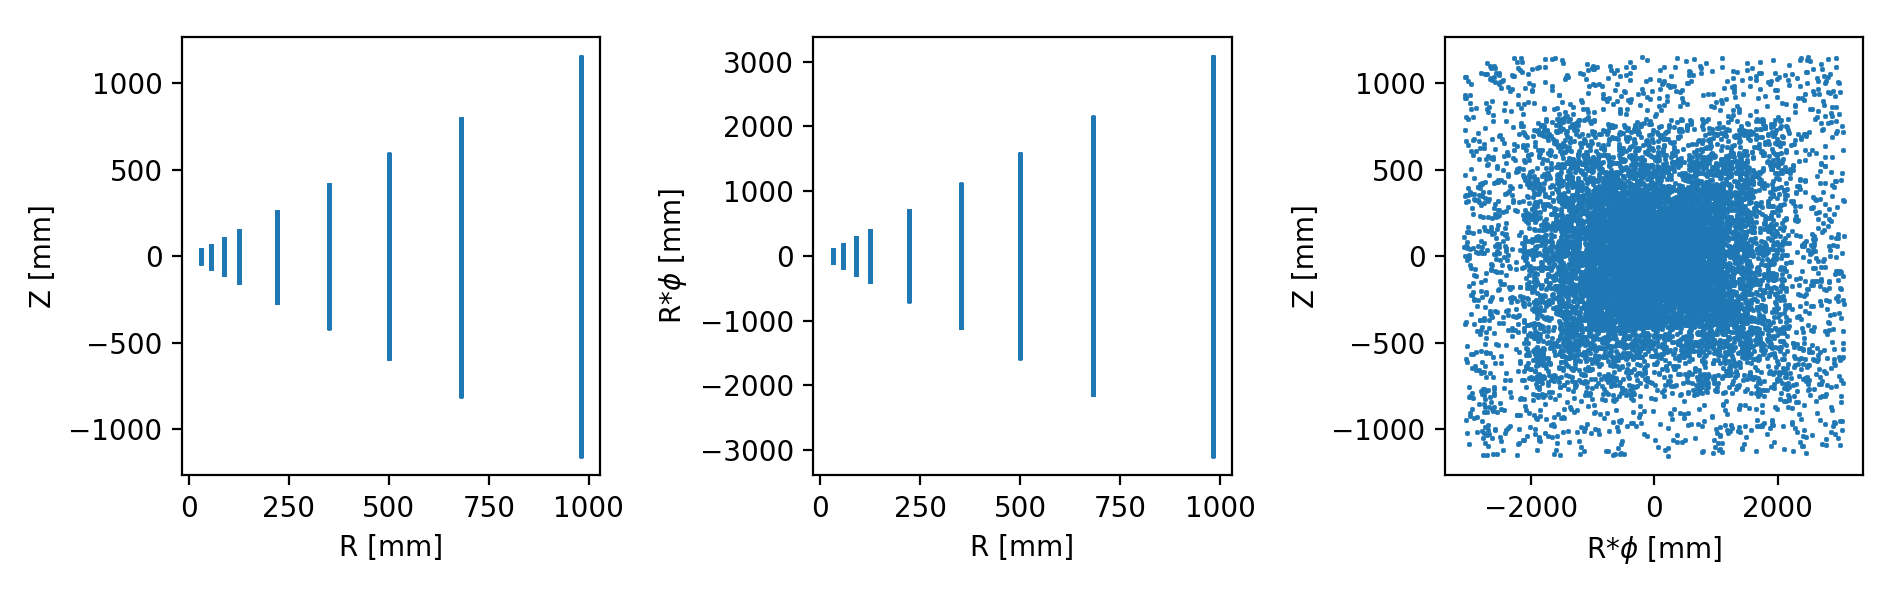

In [8]:
# Plot the distribution of hits
plt.figure(figsize=(9.5,3))
plt.subplot(131)
plt.scatter(data.r.flatten(), data.z.flatten(), s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')

plt.subplot(132)
plt.scatter(data.r.flatten(), data.rphi.flatten(), s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('R*$\phi$ [mm]')

plt.subplot(133)
plt.scatter(data.rphi.flatten(), data.z.flatten(), s=1, marker=',')
plt.xlabel('R*$\phi$ [mm]')
plt.ylabel('Z [mm]')
plt.tight_layout()

<IPython.core.display.Javascript object>


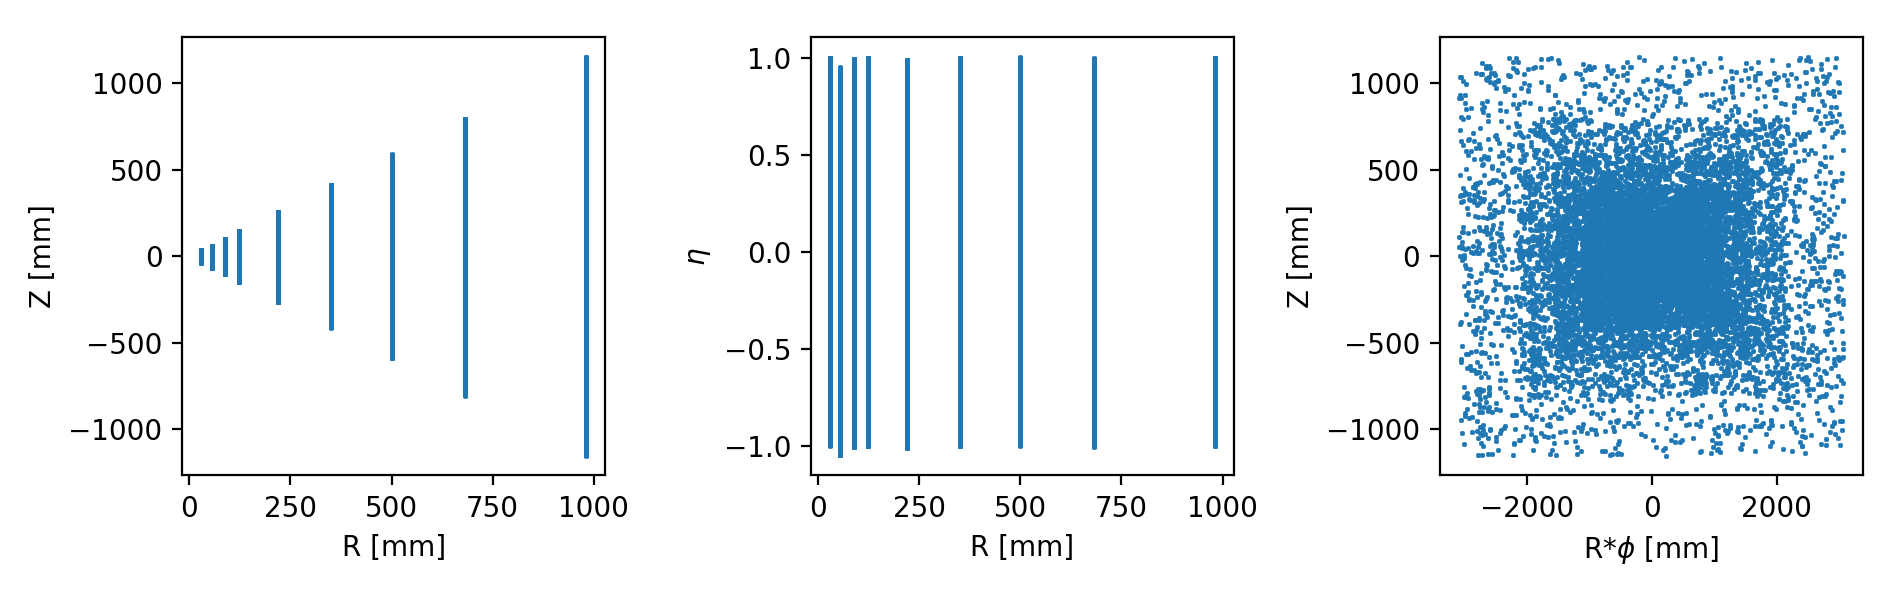

In [9]:
# Plot the distribution of hits
plt.figure(figsize=(9.5,3))
plt.subplot(131)
plt.scatter(data.r.flatten(), data.z.flatten(), s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')

plt.subplot(132)
plt.scatter(data.r.flatten(), data.eta.flatten(), s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('$\eta$')

plt.subplot(133)
plt.scatter(data.rphi.flatten(), data.z.flatten(), s=1, marker=',')
plt.xlabel('R*$\phi$ [mm]')
plt.ylabel('Z [mm]')
plt.tight_layout()

<IPython.core.display.Javascript object>


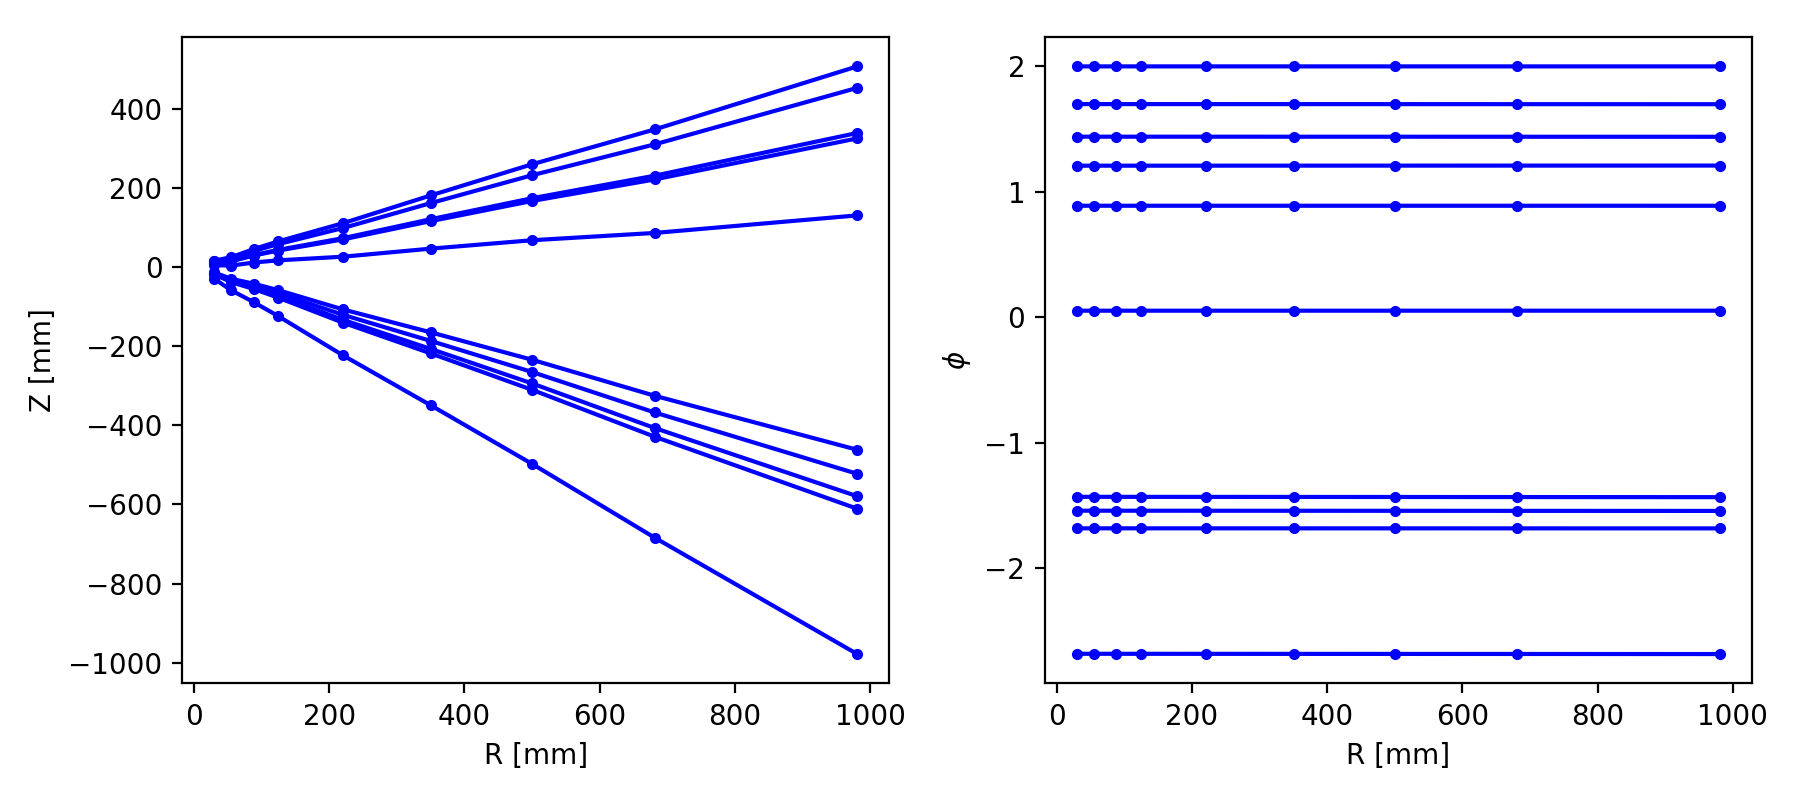

In [10]:
# Draw some tracks in 2D
plt.figure(figsize=(9,4))
num_draw = 10

plt.subplot(121)
for i in range(num_draw):
    plt.plot(data.r[i], data.z[i], 'b.-')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')

plt.subplot(122)
for i in range(num_draw):
    plt.plot(data.r[i], data.phi[i], 'b.-')
plt.xlabel('R [mm]')
plt.ylabel('$\phi$')

plt.tight_layout()

With my shitty phi correction hack, the phi distribution _seems_ well behaved.

<IPython.core.display.Javascript object>


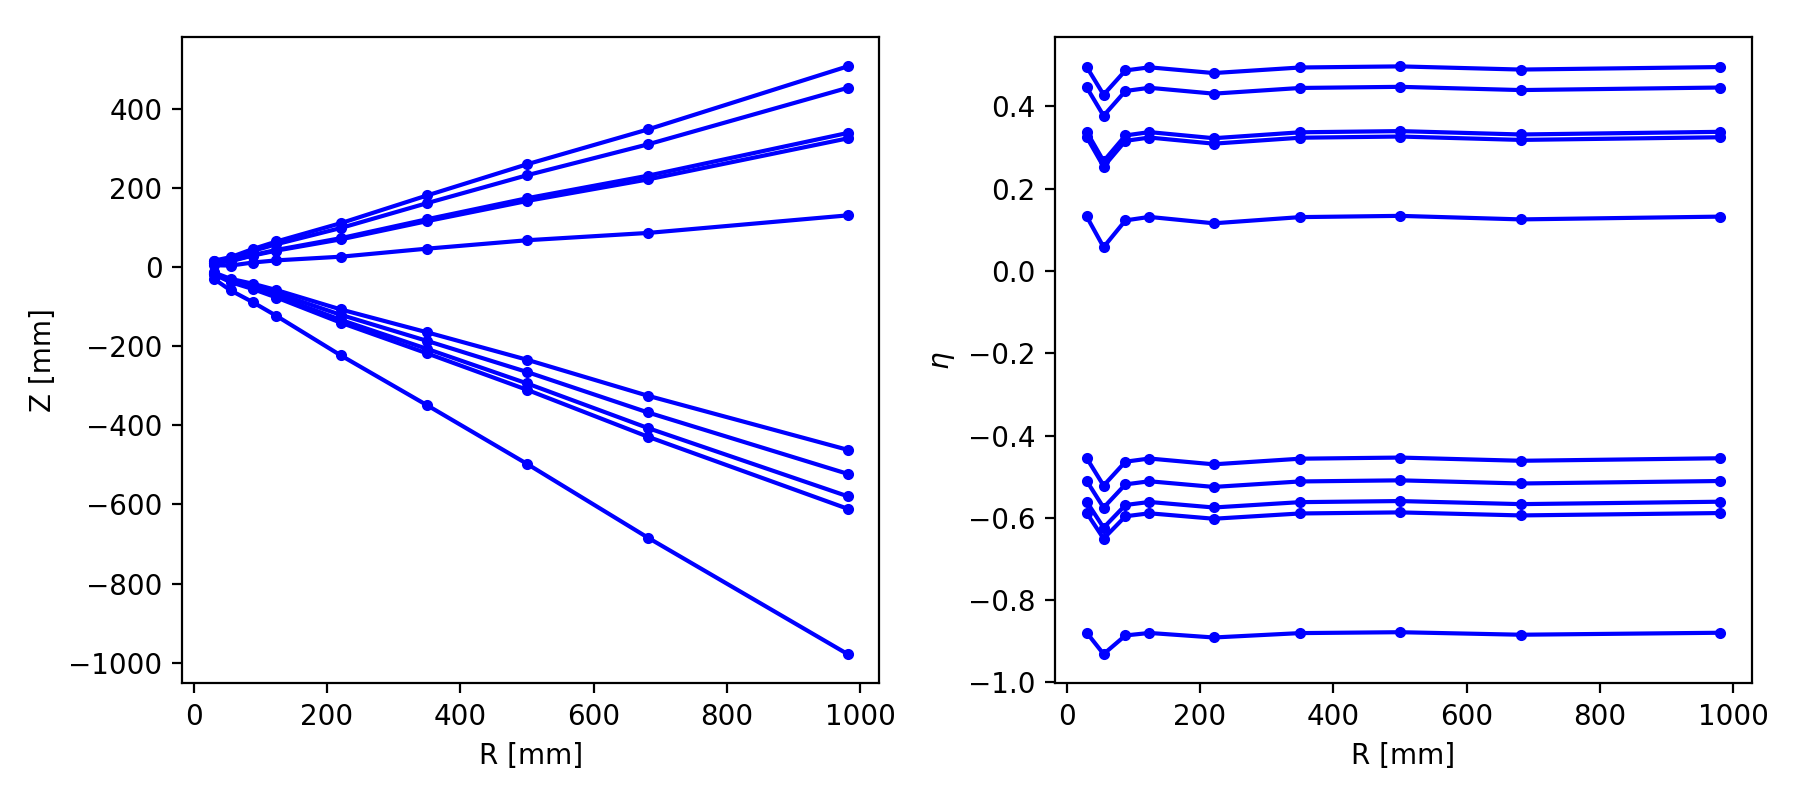

In [11]:
# Draw some tracks in 2D with eta
plt.figure(figsize=(9,4))
num_draw = 10

plt.subplot(121)
for i in range(num_draw):
    plt.plot(data.r[i], data.z[i], 'b.-')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')

plt.subplot(122)
for i in range(num_draw):
    plt.plot(data.r[i], data.eta[i], 'b.-')
plt.xlabel('R [mm]')
plt.ylabel('$\eta$')

plt.tight_layout()

Damn, it looks like $\eta$ is messed up, too. Perhaps we should avoid using eta as calculated this way for now.

## Discretizing the data

Now let's demonstrate how to bin the data into 3D "images" for ML models.

In [12]:
print('Phi range: (%.4f, %.4f)' % (data.phi.min(), data.phi.max()))
print('Z range: (%.4f, %.4f)' % (data.z.min(), data.z.max()))

Phi range: (-3.1416, 3.1416)
Z range: (-1151.5680, 1153.6256)


In [13]:
# Binning config
num_det_layers = 9
num_phi_bins = 100
num_z_bins = 100
phi_range = (-3.1416, 3.1416)
z_range = (-1155, 1155)

det_shape = (num_det_layers, num_phi_bins, num_z_bins)

In [14]:
# Initial structure with zeros
tracks = np.zeros((num_tracks,) + det_shape)

# Loop over tracks and layers
for itrk in range(num_tracks):
    for jlay in range(num_det_layers):
        # Convert coordinates for this layer to an image
        tracks[itrk, jlay] = np.histogram2d(
            data.phi[itrk, jlay:jlay+1],
            data.z[itrk, jlay:jlay+1],
            bins=[num_phi_bins, num_z_bins],
            range=[phi_range, z_range])[0]

# Check that all tracks have one hit in every layer
assert np.all(tracks.sum(axis=3).sum(axis=2) == 1.)

<IPython.core.display.Javascript object>


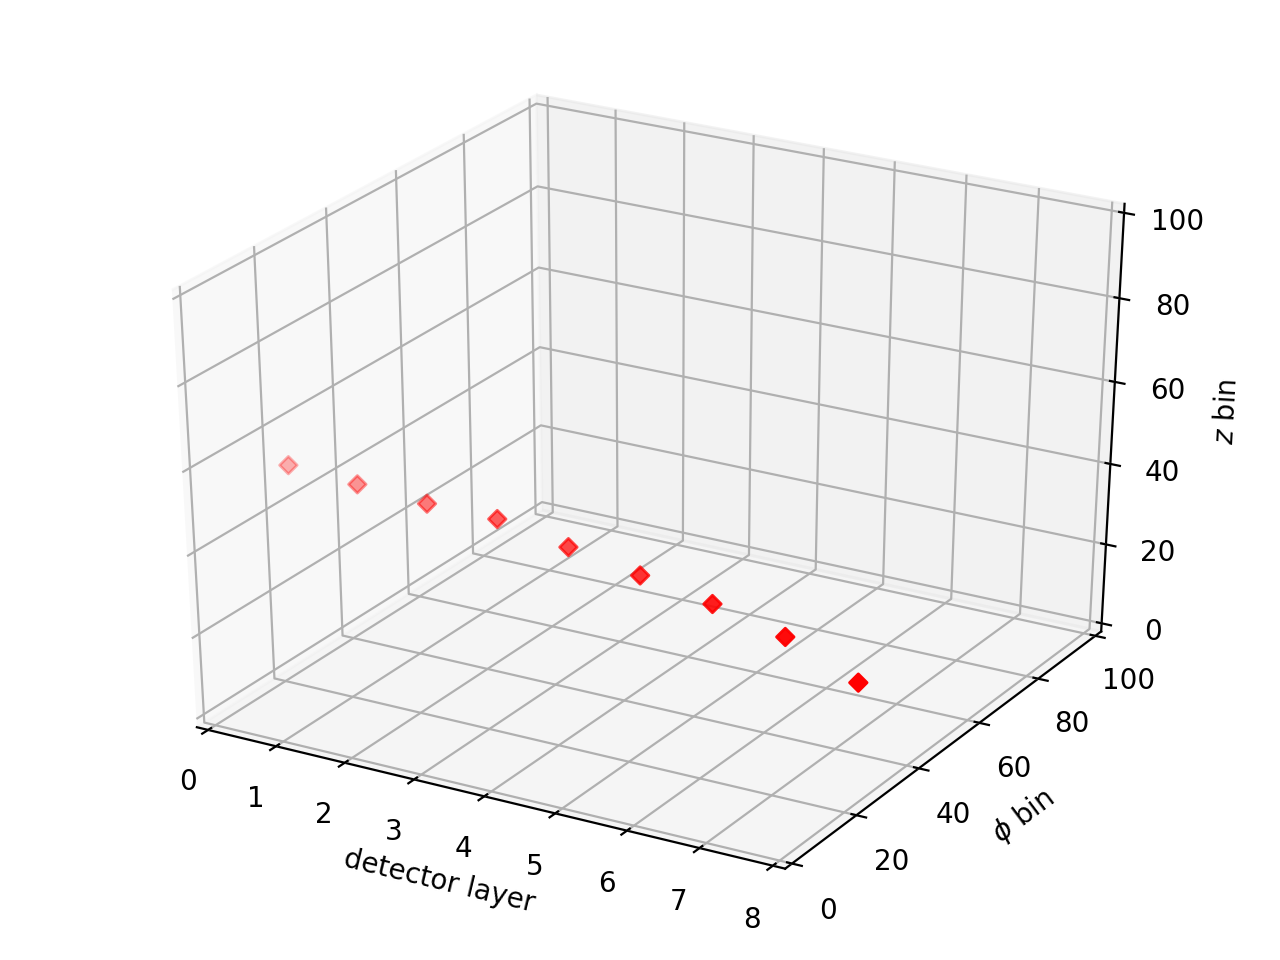

In [15]:
# Now we have to try 3D visualizations
fig, _ = draw_3d_event(tracks[0], sig_track=tracks[0], ylabel='$\phi$ bin', zlabel='$z$ bin')

In [16]:
# Plot multiple tracks
event = sum(tracks[0:10])

In [17]:
event.shape

(9, 100, 100)

<IPython.core.display.Javascript object>


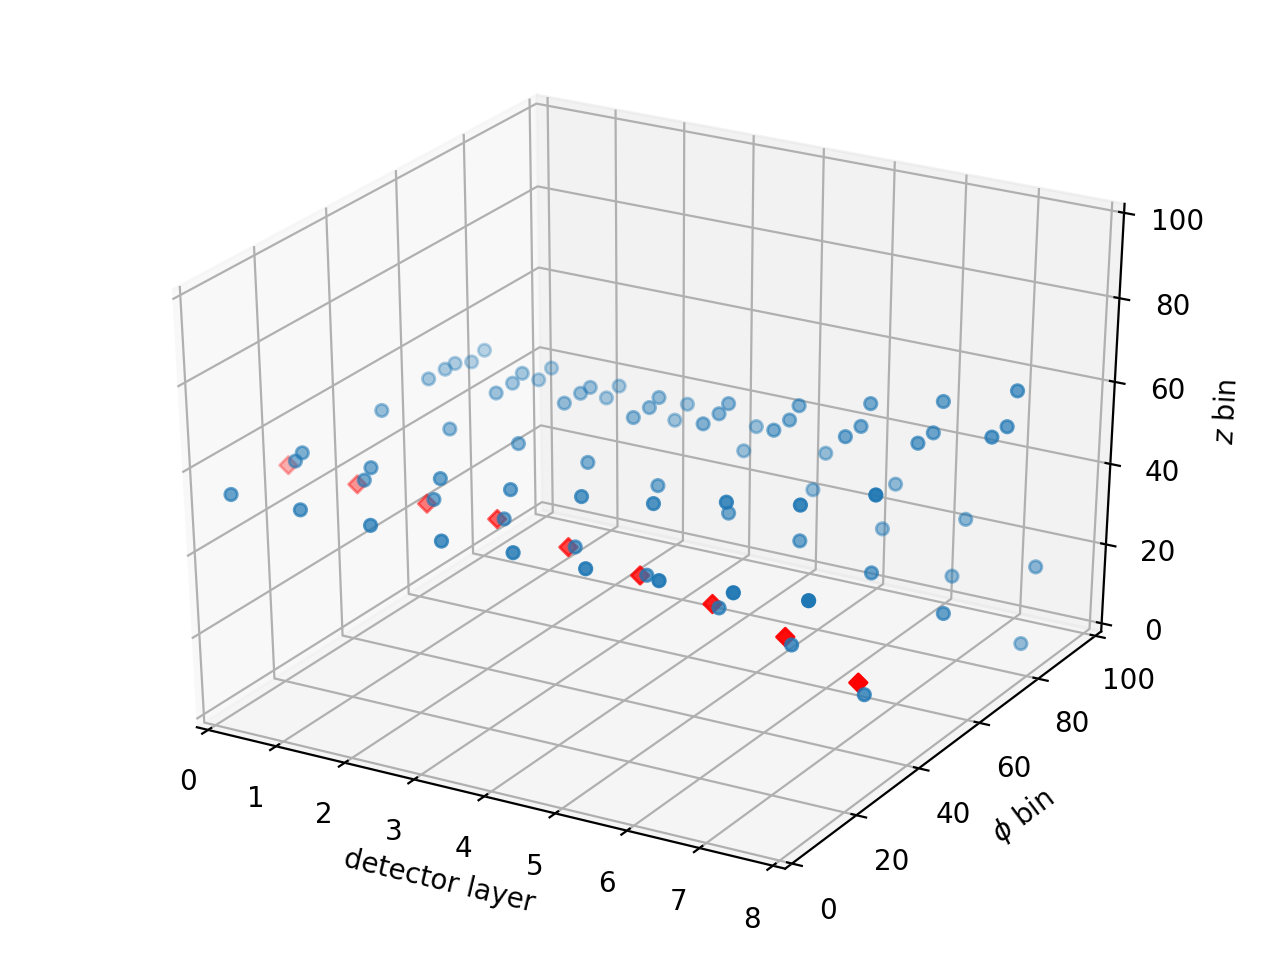

In [18]:
fig2, _ = draw_3d_event(event, sig_track=tracks[0], ylabel='$\phi$ bin', zlabel='$z$ bin')